In [2]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import sympy as sym

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#from IPython.core.debugger import set_trace
%matplotlib inline

# Utilities

In [4]:
def load_image(path):
    # Load image as RGB
    return cv2.imread(path)[:,:,::-1]

In [7]:
def find_correspondence_points(img1, img2, n_feat):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=int(n_feat))
    #sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1, pts2

In [6]:
def hstack_images(imgA, imgB):
    """
    Stacks 2 images side-by-side
    :param imgA:
    :param imgB:
    :return:
    """
    Height = max(imgA.shape[0], imgB.shape[0])
    Width  = imgA.shape[1] + imgB.shape[1]
    newImg = np.zeros((Height, Width, 3), dtype=imgA.dtype)
    newImg[:imgA.shape[0], :imgA.shape[1], :] = imgA
    newImg[:imgB.shape[0], imgA.shape[1]:, :] = imgB

    return newImg

In [8]:
def show_correspondence2(imgA, imgB, X1, Y1, X2, Y2, line_colors=None):
    """
    Visualizes corresponding points between two images. Corresponding points will
    have the same random color.
    :param imgA:
    :param imgB:
    :param x1:
    :param y1:
    :param x2:
    :param y2:
    :param line_colors: N x 3 colors of correspondence lines (optional)
    :return:
    """
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)

    dot_colors = np.random.rand(len(X1), 3)
    if imgA.dtype == np.uint8:
        dot_colors *= 255
    if line_colors is None:
        line_colors = dot_colors

    for x1, y1, x2, y2, dot_color, line_color in zip(X1, Y1, X2, Y2, dot_colors,
            line_colors):
        newImg = cv2.circle(newImg, (x1, y1), 5, dot_color, -1)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 5, dot_color, -1)
        newImg = cv2.line(newImg, (x1, y1), (x2+shiftX, y2), line_color, 2,
                                            cv2.LINE_AA)
    return newImg

In [24]:
# Dino
pic_a = load_image('Wadham/001.jpg'); scale_a = 0.65
pic_b = load_image('Wadham/003.jpg'); scale_b = 0.65
n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

In [25]:
# Use SIFT to get matching points
points_2d_pic_a, points_2d_pic_b = find_correspondence_points(pic_a, pic_b, n_feat)

C:\Users\M323742\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


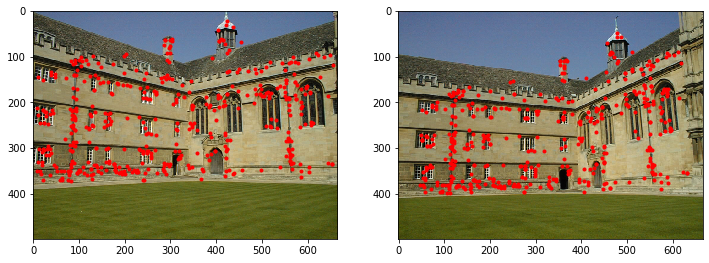

In [27]:
fig, ax = plt.subplots(1, 2,  figsize=(12,7))
ax[0].autoscale_view('tight')
ax[0].imshow(pic_a)
ax[0].plot(points_2d_pic_a[:,0], points_2d_pic_a[:,1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(pic_b)
ax[1].plot(points_2d_pic_b[:,0], points_2d_pic_b[:,1], 'r.')
fig.show()


In [61]:
match_image = show_correspondence2(pic_a, pic_b,
                                   X1=points_2d_pic_a[:, 0], 
                                   Y1=points_2d_pic_a[:, 1],
                                   X2=points_2d_pic_b[:, 0], 
                                   Y2=points_2d_pic_b[:, 1])


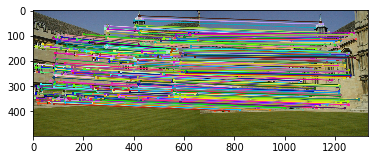

In [62]:
plt.figure(); 
plt.imshow(match_image)
plt.show()

### Estimate Fundamental Matrix From SIFT Points

In [81]:
def getPoints(points, B,num_pnts):
    cu = np.sum(points[:,0])/num_pnts
    cv = np.sum(points[:,1])/num_pnts

    s = num_pnts/np.sum(((points[:,0]-cu)**2 + (points[:,1]-cv)**2)**(1/2))
    T =np.dot(np.array([[s,0,0], [0,s,0], [0,0,1]]), np.array([[1,0,-cu],[0,1,-cv],[0,0,1]]))

    points = np.array(points.T)
    points = np.append(points,B)

    points = np.reshape(points, (3,num_pnts))
    points = np.dot(T, points)
    points = points.T

    return points, cu, cv, T

In [82]:
def estimate_fundamental_matrix(points_a, points_b):
    """
    points_a: 2D points in image A
    points_b: 2D points in image B
    Returns:
    F: A numpy array of shape (3, 3) representing the fundamental matrix
    """

    num_pnts = points_a.shape[0]
    A = []
    B = np.ones((num_pnts,1))

    points_a, cu_a, cv_a, T_a = getPoints(points_a, B, num_pnts)
    points_b, cu_b, cv_b, T_b = getPoints(points_b, B, num_pnts)

    for i in range(num_pnts):
        u_a = points_a[i,0]
        v_a = points_a[i,1]
        u_b = points_b[i,0]
        v_b = points_b[i,1]
        A.append([u_a*u_b, v_a*u_b, u_b, u_a*v_b, v_a*v_b, v_b, u_a, v_a])

    A = np.array(A)
    F = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, -B))
    F = np.append(F,[1])
   
    F = np.reshape(F,(3,3)).T
    F = np.dot(T_a.T, F)
    F = np.dot(F, T_b)

    F = F.T
    U,S,V = np.linalg.svd(F)
    S = np.array([[S[0],0,0],[0,S[1],0],[0,0,0]])
    F = np.dot(U, S)
    F = np.dot(F, V)

    return F

# Calculate Fundamental Matrix via RANSAC

In [89]:
def ransac_fundamental_matrix(matches_a, matches_b):
    """
    matches_a: array of shape (N, 2), coordinates of potential matching points from image A
    matches_b: array of shape (N, 2), coordinates of potential matching points from image B
                   
    Returns:
    F_Best: array of shape (3, 3) best fundamental matrix estimation
    inliers_a: array of shape (M, 2) subset of corresponding points from image A that are inliers with respect to F_Best
    inliers_b: array of shape (M, 2) subset of corresponding points from image B that are inliers with respect to F_Best
    """
    matches_num = matches_a.shape[0]
    Best_count = 0
    
    for iter in range(500):
        sampled_idx = np.random.randint(0, matches_num, size = 8)
        F = estimate_fundamental_matrix(matches_a[sampled_idx, :], matches_b[sampled_idx, :])
        in_a = []
        in_b = []
        update = 0
        for i in range(matches_num):
            matches_aa = np.append(matches_a[i,:],1)
            matches_bb = np.append(matches_b[i,:],1)
            error = np.dot(matches_aa, F.T)
            error = np.dot(error, matches_bb.T)
            if abs(error) < 0.05:
                in_a.append(matches_a[i,:])
                in_b.append(matches_b[i,:])
                update +=1

        if update > Best_count:
            Best_count = update
            F_Best = F
            inliers_a = in_a
            inliers_b = in_b

    inliers_a = np.array(inliers_a)
    inliers_b = np.array(inliers_b)

    return F_Best, inliers_a, inliers_b

In [90]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

In [91]:
# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(pic_a, pic_b,
                                   matched_points_a[:, 0], matched_points_a[:, 1],
                                   matched_points_b[:, 0], matched_points_b[:, 1])

# Visualize Epipolar Lines

In [92]:
def draw_epipolar_lines(F, pic, pts_a, pts_b, i):
    # lines in the image
    # corner points
    p_ul = np.asarray([0, 0, 1])
    p_ur = np.asarray([pic.shape[1], 0, 1])
    p_bl = np.asarray([0, pic.shape[0], 1])
    p_br = np.asarray([pic.shape[1], pic.shape[0], 1])

    # left and right border lines
    l_l = np.cross(p_ul, p_bl)
    l_r = np.cross(p_ur, p_br)

    ax[i].imshow(pic)
    ax[i].autoscale(False)
    ax[i].scatter(pts_a[:, 0], pts_a[:, 1], marker='*', s=20, c='yellow', edgecolors='red')
    for p in pts_b:
        p = np.hstack((p, 1))[:, np.newaxis]
        l_e = np.dot(F, p).squeeze()  # epipolar line
        p_l = np.cross(l_e, l_l)
        p_r = np.cross(l_e, l_r)
        x = [p_l[0]/p_l[2], p_r[0]/p_r[2]]
        y = [p_l[1]/p_l[2], p_r[1]/p_r[2]]
        ax[i].plot(x, y, linewidth=1, c='blue')

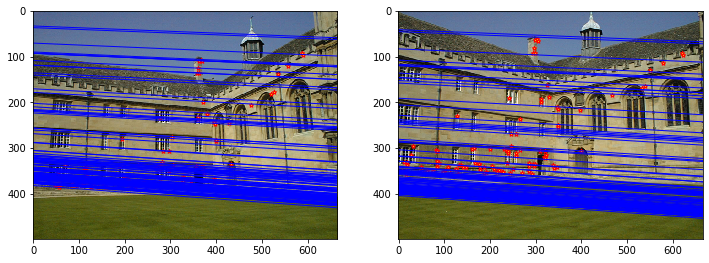

In [96]:
fig, ax = plt.subplots(1, 2,  figsize=(12,7))    
draw_epipolar_lines(F, pic=img_right, pts_a=pts_right, pts_b=pts_left, i=0)
draw_epipolar_lines(F, pic=img_left, pts_a=pts_left, pts_b=pts_right, i=1)

# Fundamental Matrix

In [35]:
sym.Matrix(np.around(F, 4))

Matrix([
[    0.0, 0.0001, -0.0151],
[    0.0,    0.0, -0.1048],
[-0.0036, 0.0751, 12.4732]])

# End

In [66]:
import gc
gc.collect()

70552

In [65]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Thursday July 29, 2021 at 15:56
